In [1]:
# TODO: generate synthetic 2d spatial+time wave problems from density
##      - Manufactured Solution:
##          - source term is determined from initial waveform but random after since waveform is also random
##          - the solution may be implausible for the given density function
##          - easier to compute for large sample sizes
##      - Computed Solution:
##          - source term is determined from inital pulse and zero for the rest
##          - solution based on density function
##          - very slow to compute especially if the mesh size used needs to be very large
##      - random shapes of different densities at random positions
##      - when overlapping, the shapes should average their density
##      - can be done by each shape adding another matrix to a list
##        of shape density matrices and then merging the non-nan density by averaging
##      - anything not in the shape is nan
##      - absolute densities like density of pvc against a dish filled with water
##        can be added at the next step where the newest density will override the working density
##      - Extra: absolute density can try as much as possible to not overlap other shapes
# TODO: try model in 3d if doesn't work

In [2]:
# TODO: least squares for coefficients from data "measured" at fixed spatial positions through time
##      - 32 positions at the circumference of a circle with a radius of 20cm 
##      - non equispaced fourier transform too complicated but possible in the future

In [3]:
%load_ext memory_profiler

In [4]:
import torch
import skripsi_program
from skripsi_program import (
    SpectralSVR,
    to_complex_coeff,
    to_real_coeff,
    FourierBasis,
    LSSVR,
    StandardScaler,
    reduce_coeff,
    zero_coeff,
    # rmse,
    # mse,
    # r2_score,
    # r2_expected_score,
)
import numpy as np
from torchmetrics.functional import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    relative_squared_error,
    symmetric_mean_absolute_percentage_error
)
from typing import Literal

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
generator = torch.Generator().manual_seed(43)
mode = 20
modes = [mode] * 2
prod_modes = int(np.prod(modes))
num_samples = 5900
k = FourierBasis.waveNumber(mode)
u_coeff_clean = FourierBasis.generateCoeff(
    num_samples, prod_modes, generator=generator, random_func=torch.rand
).view(num_samples, *modes)
# reweigh coefficients so that different modes are higher or lower
ut_coeff_clean = u_coeff_clean * 2j * torch.pi * (k.T * k) / prod_modes
utt_coeff_clean = ut_coeff_clean * 2j * torch.pi * (k.T * k) / prod_modes  # d2f/dt2
# u_coeff = u_coeff.reshape((-1, *modes))
# f_coeff = f_coeff.reshape((-1, *modes))
u_coeff_clean.shape, utt_coeff_clean.shape

(torch.Size([5900, 20, 20]), torch.Size([5900, 20, 20]))

def visualize_dist_coeff(dim=0):
    fig, axs = plt.subplots(1, 3, figsize=[15,3])

    axs[0].hist(u_coeff_clean[:,dim].real, bins = 20)
    axs[0].set_title("u")
    axs[1].hist(ut_coeff_clean[:,dim].imag/8, bins = 20)
    axs[1].set_title("ut")
    axs[2].hist(utt_coeff_clean[:,dim].real/32, bins = 20)
    axs[2].set_title("utt")
    plt.show()
visualize_dist_coeff(2)

{'u_shape': torch.Size([5900, 100, 100]),
 'r2': 0.52447110414505,
 'mse': 0.15849056839942932,
 'psnr': 15.999923706054688}

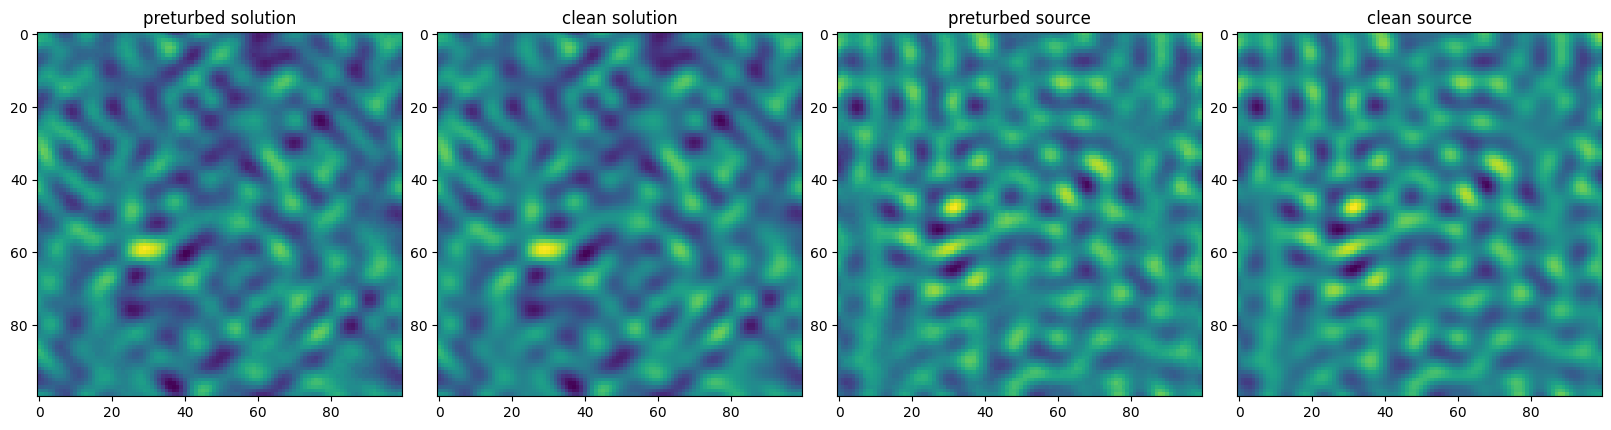

In [7]:
wave_speed = 1.0
period = 1.0
periods = [period] * len(modes)
sample_freq = 100.0
sample_step = period / sample_freq
t = torch.arange(0, 1, sample_step)
tmp = [t for i in range(len(modes))]
tt = torch.meshgrid(tmp, indexing="ij")
tt_flat = [t.flatten() for t in tt]
points_tt = torch.concat([t.unsqueeze(-1) for t in tt_flat], 1)
u_basis = FourierBasis(u_coeff_clean, periods)
u_clean = u_basis.evaluate(points_tt).real.view((-1, *(int(sample_freq),) * 2))
ut_clean = torch.gradient(u_clean, spacing=sample_step, dim=1, edge_order=2)[0]
ux_clean = torch.gradient(u_clean, spacing=sample_step, dim=2, edge_order=2)[0]
utt_clean = torch.gradient(ut_clean, spacing=sample_step, dim=1, edge_order=2)[0]
uxx_clean = torch.gradient(ux_clean, spacing=sample_step, dim=2, edge_order=2)[0]
f_clean = uxx_clean - 1 / wave_speed**2 * utt_clean
noise_ratio = 0.05
# u = u_clean
# f = f_clean
# u_coeff = u_coeff_clean
# f_coeff = u_coeff_clean
u = u_clean + torch.randn_like(u_clean) * noise_ratio * u_clean.std()
ut = ut_clean + torch.randn_like(ut_clean) * noise_ratio * ut_clean.std()
ux = ux_clean + torch.randn_like(ux_clean) * noise_ratio * ux_clean.std()
utt = utt_clean + torch.randn_like(utt_clean) * noise_ratio * utt_clean.std()
uxx = uxx_clean + torch.randn_like(uxx_clean) * noise_ratio * uxx_clean.std()
f = f_clean + torch.randn_like(f_clean) * noise_ratio * f_clean.std()
u_coeff = reduce_coeff(FourierBasis.transform(u), modes)
ut_coeff = reduce_coeff(FourierBasis.transform(ut), modes)
ux_coeff = reduce_coeff(FourierBasis.transform(ux), modes)
utt_coeff = reduce_coeff(FourierBasis.transform(utt), modes)
uxx_coeff = reduce_coeff(FourierBasis.transform(uxx), modes)
f_coeff = reduce_coeff(FourierBasis.transform(f), modes)
u_shape = u.shape


def signal_stats():
    # u_real, u_clean_real = to_real_coeff(u), to_real_coeff(u_clean)
    u_real, u_clean_real = (
        to_real_coeff(u_coeff.flatten(1)),
        to_real_coeff(u_coeff_clean.flatten(1)),
    )
    r2 = r2_score(u_real, u_clean_real)
    mse = mean_squared_error(u_real, u_clean_real)
    psnr = 20 * u_clean_real.max().log10() - 10 * mse.pow(2).log10()
    display(
        {
            "u_shape": u_shape,
            "r2": r2.item(),
            "mse": mse.item(),
            "psnr": psnr.item(),
        }
    )


signal_stats()


def tmp_plot():
    n = 0
    plt.figure(figsize=(16, 4), constrained_layout=True)
    plt.subplot(141)
    plt.imshow(u[n].real)
    plt.title("preturbed solution")
    plt.subplot(142)
    plt.imshow(u_clean[n].real)
    plt.title("clean solution")
    plt.subplot(143)
    plt.imshow(f[n].real)
    plt.title("preturbed source")
    plt.subplot(144)
    plt.imshow(f_clean[n].real)
    plt.title("clean source")
    # x = torch.arange(-1, 1, sample_step)
    # tmp = [x for i in range(len(modes))]
    # xx = torch.meshgrid(tmp, indexing="ij")
    # points = torch.concat([x.flatten().unsqueeze(-1) for x in xx], 1)
    # u_eval = (
    #     FourierBasis(u_coeff[n, None], periods=periods)
    #     .evaluate(points)
    #     .view((-1, *xx[0].shape))
    # )
    # u_clean_eval = (
    #     FourierBasis(u_coeff_clean[n, None], periods=periods)
    #     .evaluate(points)
    #     .view((-1, *xx[0].shape))
    # )
    # plt.subplot(245)
    # plt.imshow(u_eval[0].real)
    # plt.title("preturbed solution coefficients evaluated outside of period")
    # plt.subplot(247)
    # plt.imshow(u_clean_eval[0].real)
    # plt.title("clean solution coefficients evaluated outside of period")
    plt.show()


tmp_plot()

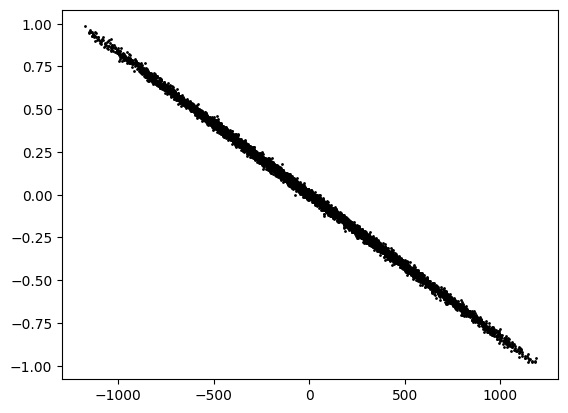

In [8]:

plt.plot(f_coeff[:,18,6].real,u_coeff[:,18,6].real, 'ko', ms=1)
plt.show()

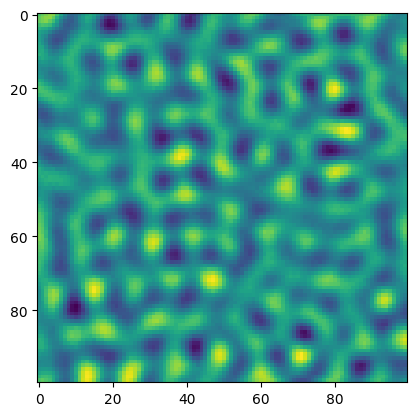

In [9]:
from torch.utils.data import TensorDataset, random_split

input_data = (f.flatten(1), f_coeff.flatten(1))
output_data = (u.flatten(1), u_coeff.flatten(1))
# data = (utt, utt_coeff, u, u_coeff_zeroed)
# (utt_scaled, utt_coeff_scaled, u_scaled, u_coeff_scaled) = data
scaler = StandardScaler().fit(input_data)
input_data_scaled = scaler.transform(input_data)
# input_data_scaled = input_data
dataset = TensorDataset(*input_data_scaled, *output_data)
dataset_train, dataset_test = random_split(
    dataset, (0.8, 0.2), generator=torch.Generator().manual_seed(42)
)
# f_train, f_coeff_train, u_train, u_coeff_train = dataset_train[:]
# f_test, f_coeff_test, u_test, u_coeff_test = dataset_test[:]
# f_train.shape, f_coeff_train.shape, u_coeff_train.shape
plt.imshow(dataset[3][0].view(utt.shape[1:]))
plt.show()

In [10]:
f_train, f_coeff_train, u_train, u_coeff_train = dataset_train[:]
# f_input_train = f_train
f_input_train = to_real_coeff(f_coeff_train)
f_test, f_coeff_test, u_test, u_coeff_test = dataset_test[:]
# f_input_test = f_test
f_input_test = to_real_coeff(f_coeff_test)

# model = SpectralSVR(FourierBasis(periods=periods), C=41.6207,sigma=4.0776, kernel="linear")
model = SpectralSVR(
    FourierBasis(periods=periods),
    C=1.027,
    # C=100.10,
    # sigma=1.0,
    sigma=f_input_train.var(0).sum().pow(0.5) * 1.0,
    # sigma=70.0,
    kernel="linear",
    # kernel="rbf",
    # verbose="LSSVR",
    batch_size_func=lambda dims: 800000,
)
# model.train(f_input_train, u_coeff_train * 900/200, list(u_coeff_zeroed.shape[1:]))
model.train(f_input_train, u_coeff_train, modes).test(f_input_test, u_coeff_test)
# lssvr.fit(points_sampled, u_sampled.T)

transform u_coeff to real


{'mse': 0.015374692156910896,
 'rmse': 0.12399472296237946,
 'mae': 0.03947215527296066,
 'r2': 0.9079331159591675,
 'r2_abs': 0.9079331159591675,
 'smape': 0.21934659779071808,
 'rse': 0.09206695854663849,
 'rrse': 0.1201125830411911,
 'pred_nan_sum': 0}

In [11]:

from torch.profiler import profile, record_function, ProfilerActivity

with profile(
    activities=[ProfilerActivity.CPU], profile_memory=True, record_shapes=True
) as prof:
    # model.train(f_input_train, u_coeff_train, modes)#.test(f_input_test, u_coeff_test)
    FourierBasis.fn(points_tt,modes=modes, periods=periods)

print(prof.key_averages().table(sort_by="self_cpu_memory_usage"))

-----------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-----------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
    aten::empty_strided         0.06%     158.000us         0.06%     158.000us      26.333us      30.52 Mb      30.52 Mb             6  
              aten::exp        32.66%      90.051ms        32.66%      90.051ms      90.051ms      30.52 Mb      30.52 Mb             1  
              aten::add        21.33%      58.819ms        21.33%      58.819ms      29.410ms      16.02 Mb      16.02 Mb             2  
               aten::mm        16.99%      46.835ms        16.99%      46.835ms      23.418ms       1.53 Mb       1.53 Mb             2  
            aten::empty         0.

In [12]:
u_pred = model.forward(f_input_test, points_tt)
u_coeff_pred = to_complex_coeff(model.svr.predict(f_input_test))
# u_coeff_pred = u_coeff_pred * u_coeff_test.std() / u_coeff_pred.std()
# u_coeff_pred = to_complex_coeff(model.svr.predict(f_input_test))
u_pred_basis = FourierBasis(u_coeff_pred.view((-1, *modes)), periods)
u_basis_pred = u_pred_basis.evaluate(points_tt).real.view((-1, *tt[0].shape))
# u_pred = lssvr.predict(points_tt).T
u_pred.shape

torch.Size([1180, 10000])

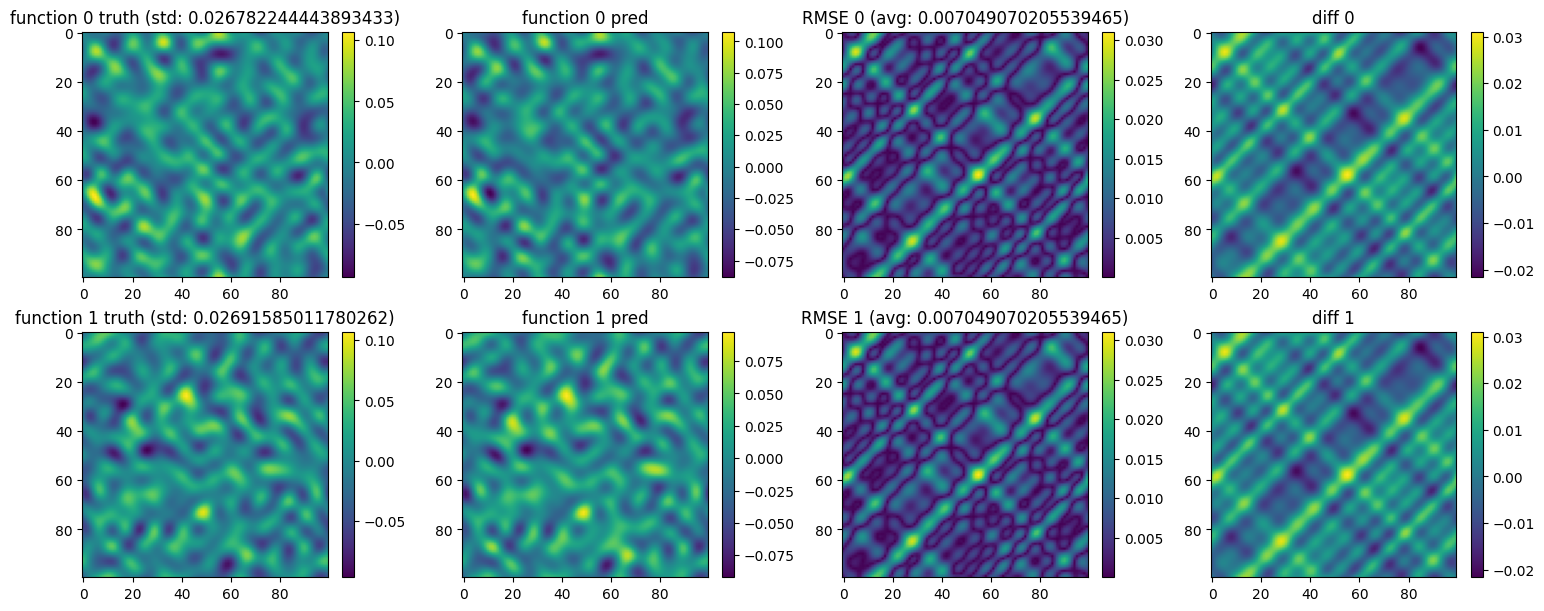

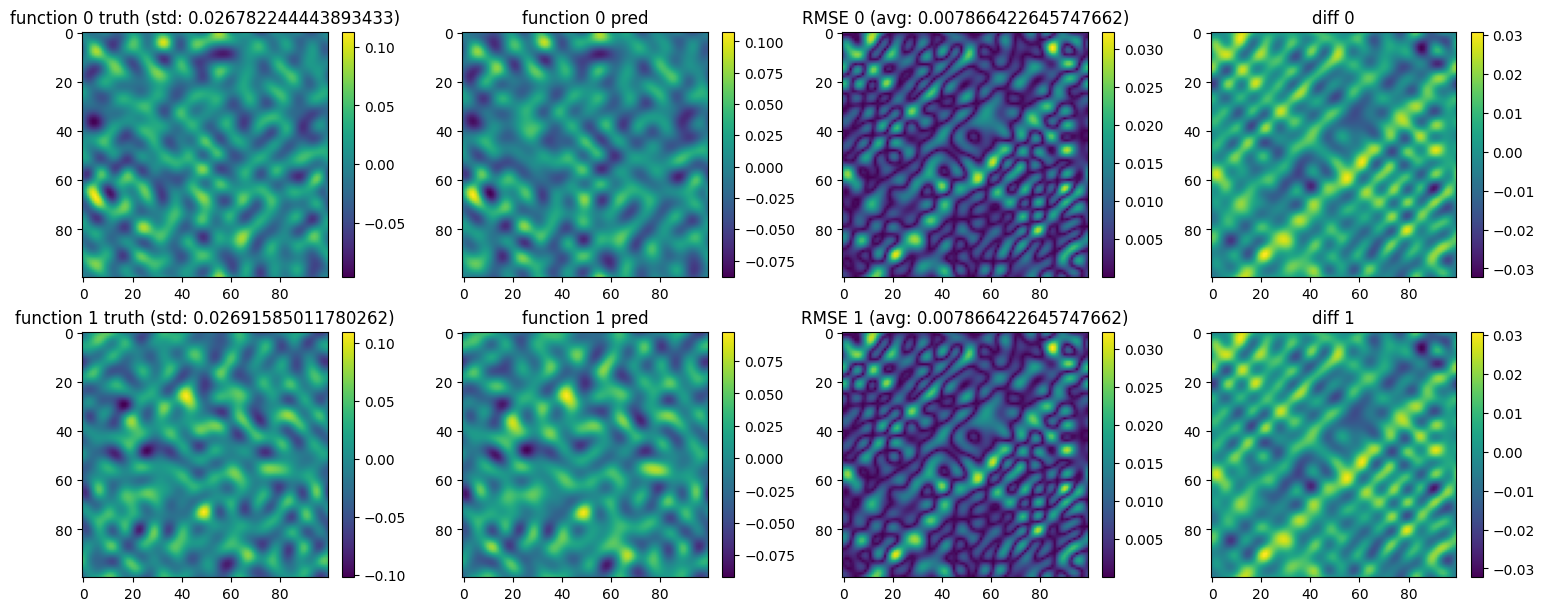

In [13]:
# do this because forward in SpectralSVR isn't scaling invariant
u_test_eval = (
    FourierBasis(u_coeff_test.view((-1, *modes)))
    .evaluate(points_tt)
    .real.view((-1, *tt[0].shape))
)
# u_coeff_clean_scaled = u_coeff_clean
# u_coeff_clean_scaled = scaler.get_subset_scaler([-1]).transform((u_coeff_clean,))[0][dataset_test.indices]
u_coeff_clean_eval = (
    FourierBasis(u_coeff_clean[dataset_test.indices].view((-1, *modes)))
    .evaluate(points_tt)
    .real.view((-1, *tt[0].shape))
)


def plot_funcs(u_pred: torch.Tensor, u: torch.Tensor, n=6):
    # line_styles = ["solid", "dotted", "dashed", "dashdot"]
    fig, axs = plt.subplots(n, 4, figsize=[15, n * 3], constrained_layout=True)
    for i in range(n):
        z = axs[i, 0].imshow(u[i].real)
        plt.colorbar(z, ax=axs[i, 0])
        axs[i, 0].set_title(f"function {i} truth (std: {u_pred[i].real.std()})")
        z_pred = axs[i, 1].imshow(u_pred[i].real)
        plt.colorbar(z_pred, ax=axs[i, 1])
        axs[i, 1].set_title(f"function {i} pred")
        rmse = mean_squared_error(
            u_pred[n].flatten(0).unsqueeze(0),
            u[n].flatten(0).unsqueeze(0),
            squared=False,
            num_outputs=int(np.prod(tt[0].shape)),
        ).view(tt[0].shape)
        z_rmse = axs[i, 2].imshow(rmse)
        plt.colorbar(z_rmse, ax=axs[i, 2])
        axs[i, 2].set_title(f"RMSE {i} (avg: {rmse.mean()})")
        z_diff = axs[i, 3].imshow(u_pred[n] - u[n])
        plt.colorbar(z_diff, ax=axs[i, 3])
        axs[i, 3].set_title(f"diff {i}")

    plt.show()


# plot_funcs(u_pred.real, u_test_eval.real, 2)
# plot_funcs(u_pred, u_coeff_clean_eval, 2)
plot_funcs(u_basis_pred.real, u_test_eval.real, 2)
plot_funcs(u_basis_pred.real, u_coeff_clean_eval, 2)

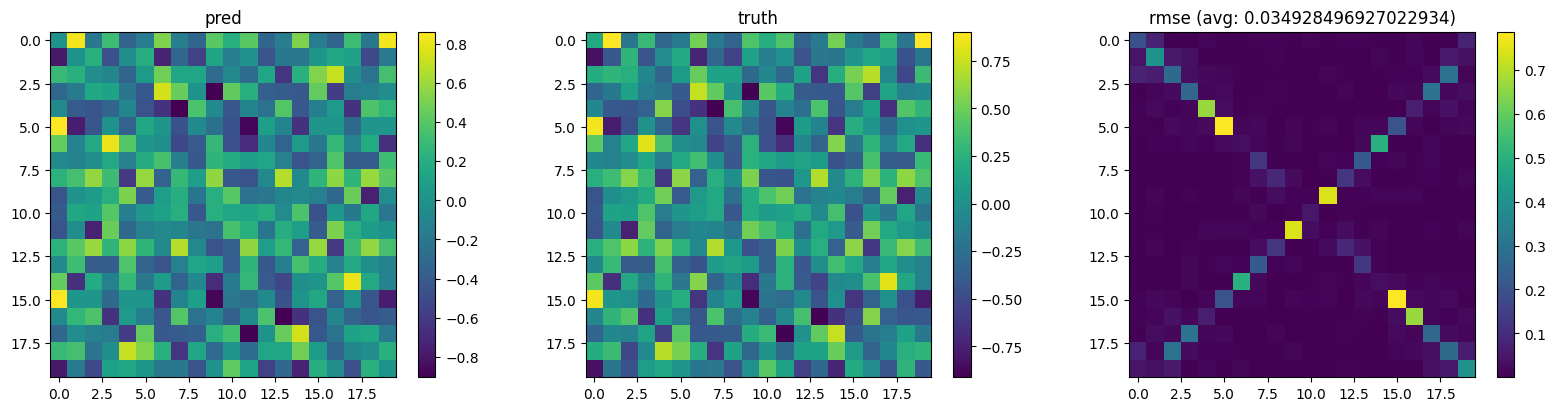

In [14]:
def plot_coeffs(coeff_pred: torch.Tensor, coeff: torch.Tensor, n=0):
    plt.figure(figsize=(16, 4), constrained_layout=True)
    plt.subplot(131)
    plt.imshow(coeff_pred[n].real.view(modes))
    plt.title("pred")
    plt.colorbar()
    plt.subplot(132)
    plt.imshow(coeff[n].real.view(modes))
    plt.title("truth")
    plt.colorbar()
    plt.subplot(133)
    mse = mean_squared_error(
        coeff_pred[n].real.unsqueeze(0),
        coeff[n].real.unsqueeze(0),
        squared=False,
        num_outputs=coeff.shape[1],
    ).view(modes)

    plt.imshow(mse)
    plt.colorbar()
    plt.title(f"rmse (avg: {mse.mean()})")
    plt.show()



plot_coeffs(u_coeff_pred, u_coeff_test, 3)

In [15]:
mean_squared_error(
            u_coeff_pred[0].real.unsqueeze(0),
            u_coeff_test[0].real.unsqueeze(0),
            squared=False,
            num_outputs=u_coeff_test.shape[1],
        ).shape

torch.Size([400])

In [16]:
f_test, f_coeff_test, u_test, u_coeff_test = dataset_test[0:10]
u_test_basis = FourierBasis(u_coeff_test.view((-1,*modes)), periods=periods)
u_inv = u_test_basis.evaluate(points_tt).real
inverse_pred = model.inverse(u_inv, points_tt, epochs=400, lr=1e-2, loss_fn=mean_squared_error, gain=1e-4).detach()


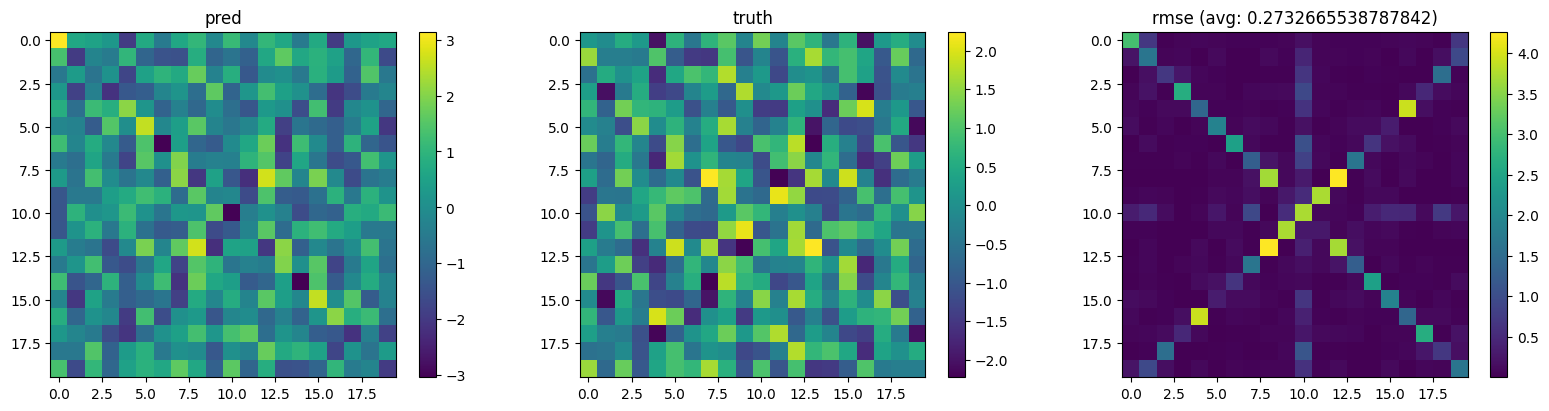

In [17]:
f_truth = f_coeff_test
# f_truth = to_real_coeff(f_coeff_test)
# f_truth = FourierBasis(periods=periods).evaluate(points_tt, f_coeff_test, periods,modes=modes).real
# plot_funcs(inverse_pred, f_truth, n=10)
plot_coeffs(to_complex_coeff(inverse_pred), f_truth)

In [18]:
preds = to_complex_coeff(inverse_pred).real
targets = f_truth.real
(
    mean_squared_error(preds, targets),
    r2_score(preds, targets),
    mean_absolute_error(preds, targets),
    symmetric_mean_absolute_percentage_error(preds, targets),
    f_truth.shape,
)


(tensor(0.3756),
 tensor(0.5439),
 tensor(0.2323),
 tensor(0.3449),
 torch.Size([10, 400]))